## **2.2 Multi-Task Model Architecture**

The model is formulated as a **multi-task learning system**, where a single shared representation supports multiple prediction objectives.

### **2.2.2 Shared Backbone: The “Master” Feature Finder**

The core of the architecture is a **ResNet-34 CNN** used as a **shared feature extractor** for all three tasks.

Instead of training separate networks for age, gender, and race, the model first learns a strong, general-purpose **face representation**, which is then reused by task-specific heads.

* **Input:** Preprocessed face images.
* **Output:** A compact embedding capturing facial structure, texture, and shape.
* **Benefit:** Since all tasks backpropagate through the same backbone, the learned representation generalizes across labels instead of overfitting to a single task.

#### **2.2.2.1 The Input–Output Handshake**

Before implementing task-specific logic, a strict contract is defined:

* **Input:** A batch of face images resized and normalized to $(B, 3, 224, 224)$.
* **Output:** A 512-dimensional embedding per image.
* **Shape Guarantee:** A batch of size $B$ produces an output tensor of shape $(B, 512)$.

This contract ensures that downstream heads can be attached cleanly and independently.

#### **2.2.2.2 Surgery: Turning a Classifier into a Feature Finder**

A standard ResNet-34 is trained to classify 1,000 ImageNet categories. These final class predictions are not useful for facial attribute learning.

* **The Operation:** The final classification layer is removed.
* **Stopping Point:** The network is truncated after the **Global Average Pooling** stage.
* **Cleanup:** The pooled tensor $(B, 512, 1, 1)$ is flattened into a clean $(B, 512)$ embedding.

This transforms ResNet-34 from an object classifier into a reusable feature extractor.

#### **2.2.2.3 Training Strategy: Let the Backbone Learn**

For the baseline model, the backbone is **fine-tuned**, not frozen.

* **Full Gradient Flow:** All backbone parameters remain trainable.
* **Shared Learning Signal:** Errors from age, gender, and race predictions all update the same representation.
* **Result:** The backbone learns facial features that are broadly useful across tasks.

#### **2.2.2.4 Trust-but-Verify Sanity Checks**

Before large-scale training, two sanity checks validate correctness:

1. **Shape Check:** A dummy input must produce exactly a 512-dimensional embedding.
2. **Gradient Check:** A backward pass must propagate gradients into backbone parameters.

These checks ensure the backbone is actively learning and not acting as a frozen observer.

In [1]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, Literal

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

In [2]:
ff_train_df = pd.read_csv('/home/onkar/projects/data/fairface/splits/ff_train.csv')
ff_train_df.head(10)

,file,age,gender,race,service_test,split
0,train/83377.jpg,50-59,Female,Indian,False,train
1,train/84431.jpg,20-29,Male,Black,True,train
2,train/682.jpg,20-29,Female,Latino_Hispanic,True,train
3,train/5478.jpg,40-49,Male,Middle Eastern,False,train
4,train/45214.jpg,30-39,Male,Southeast Asian,False,train
5,train/11276.jpg,40-49,Male,East Asian,True,train
6,train/65931.jpg,50-59,Female,East Asian,True,train
7,train/72645.jpg,20-29,Female,Southeast Asian,False,train
8,train/86050.jpg,10-19,Female,Indian,False,train
9,train/44783.jpg,30-39,Female,Indian,False,train


In [3]:
ff_valid_df = pd.read_csv('/home/onkar/projects/data/fairface/splits/ff_val.csv')
ff_valid_df.head(10)

,file,age,gender,race,service_test,split
0,train/3285.jpg,20-29,Female,East Asian,False,val
1,train/8561.jpg,30-39,Male,Southeast Asian,True,val
2,val/2503.jpg,20-29,Male,Southeast Asian,True,val
3,train/51659.jpg,20-29,Male,White,True,val
4,val/1482.jpg,10-19,Male,Southeast Asian,False,val
5,val/7815.jpg,20-29,Female,White,False,val
6,val/5324.jpg,40-49,Male,White,False,val
7,train/60461.jpg,20-29,Female,Middle Eastern,True,val
8,train/28122.jpg,50-59,Male,Latino_Hispanic,False,val
9,train/68788.jpg,20-29,Female,Indian,True,val


In [4]:
ff_test_df = pd.read_csv('/home/onkar/projects/data/fairface/splits/ff_test.csv')
ff_test_df.head(10)

,file,age,gender,race,service_test,split
0,val/8440.jpg,30-39,Female,White,False,test
1,train/58829.jpg,20-29,Female,Black,True,test
2,train/25607.jpg,30-39,Male,East Asian,True,test
3,train/83916.jpg,30-39,Female,White,False,test
4,val/4051.jpg,3-9,Male,East Asian,True,test
5,train/75496.jpg,30-39,Female,Latino_Hispanic,False,test
6,train/53677.jpg,30-39,Male,Black,True,test
7,train/11646.jpg,3-9,Male,Indian,False,test
8,train/78166.jpg,3-9,Female,Middle Eastern,True,test
9,train/44393.jpg,30-39,Female,White,False,test


**The LabelEncoder:** 

In [5]:
class LabelEncoder:
    def __init__(self):
        self.to_id: Dict[str, int] = {}
        self.to_name: Dict[int, str] = {}

    def fit(self, values) -> "LabelEncoder":
        uniq = sorted(pd.Series(values).astype(str).unique().tolist())
        self.to_id = {name: i for i, name in enumerate(uniq)}
        self.to_name = {i: name for name, i in self.to_id.items()}
        return self

    def encode_one(self, v) -> int:
        v = str(v)
        if v not in self.to_id:
            raise KeyError(f"Unseen label '{v}' (not in train).")
        return self.to_id[v]

@dataclass
class FairFaceEncoders:
    age: LabelEncoder
    gender: LabelEncoder
    race: LabelEncoder

class FairFaceEncoderBuilder:
    @staticmethod
    def fit(train_df: pd.DataFrame) -> FairFaceEncoders:
        return FairFaceEncoders(
            age=LabelEncoder().fit(train_df["age"]),
            gender=LabelEncoder().fit(train_df["gender"]),
            race=LabelEncoder().fit(train_df["race"]),
        )

**FairFaceDataset**

In [6]:


class FairFaceDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        images_root: str | Path,
        encoders,
        *,
        mode: Literal["train", "eval"] = "train",
        train_tfms=None,
        eval_tfms=None,
    ):
        self.df = df.reset_index(drop=True).copy()
        self.root = Path(images_root)
        self.enc = encoders
        self.mode = mode

        if self.mode not in ("train", "eval"):
            raise ValueError(f"mode must be 'train' or 'eval', got: {self.mode!r}")
        if not self.root.exists():
            raise FileNotFoundError(f"images_root not found: {self.root}")

        required = {"file", "age", "gender", "race"}
        missing = required - set(self.df.columns)
        if missing:
            raise KeyError(f"Missing columns in df: {missing}. Have: {list(self.df.columns)}")

        # mode-specific transform requirement
        if self.mode == "train":
            if train_tfms is None:
                raise ValueError("mode='train' requires train_tfms (cannot be None).")
            self.img_tfms = train_tfms
        else:  # eval
            if eval_tfms is None:
                raise ValueError("mode='eval' requires eval_tfms (cannot be None).")
            self.img_tfms = eval_tfms

    def __len__(self) -> int:
        return len(self.df)

    def _img_path(self, rel_path: str) -> Path:
        return self.root / rel_path

    def _transform_image(self, img_path: Path) -> torch.Tensor:
        img_bgr = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
        if img_bgr is None:
            raise FileNotFoundError(f"Image not found or unreadable: {img_path}")
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        return self.img_tfms(img_rgb)  # exactly your pattern

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        row = self.df.iloc[idx]

        rel_path = str(row["file"])
        img_path = self._img_path(rel_path)
        img_t = self._transform_image(img_path)

        y = {
            "age": torch.tensor(self.enc.age.encode_one(row["age"]), dtype=torch.long),
            "gender": torch.tensor(self.enc.gender.encode_one(row["gender"]), dtype=torch.long),
            "race": torch.tensor(self.enc.race.encode_one(row["race"]), dtype=torch.long),
        }

        meta = {"file": rel_path, "path": str(img_path), "mode": self.mode}
        
        return {"img_t": img_t, "y": y, "meta": meta}

In [7]:
TARGET_H, TARGET_W = 224, 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

data_root = Path("/home/onkar/projects/data/fairface")
splits_dir = data_root / "splits"

ff_train_df = pd.read_csv(splits_dir / "ff_train.csv")
ff_val_df   = pd.read_csv(splits_dir / "ff_val.csv")
ff_test_df  = pd.read_csv(splits_dir / "ff_test.csv")

encoders = FairFaceEncoderBuilder.fit(ff_train_df)

train_tfms = T.Compose([
        T.ToTensor(),
        T.RandomHorizontalFlip(p=0.5),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])

eval_tfms = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])

train_ds = FairFaceDataset(ff_train_df, data_root, encoders, mode="train", train_tfms=train_tfms)
val_ds   = FairFaceDataset(ff_val_df,   data_root, encoders, mode="eval",  eval_tfms=eval_tfms)
test_ds  = FairFaceDataset(ff_test_df,  data_root, encoders, mode="eval",  eval_tfms=eval_tfms)

[{'file': 'train/77689.jpg', 'path': '/home/onkar/projects/data/fairface/train/77689.jpg', 'mode': 'train'}, {'file': 'train/45489.jpg', 'path': '/home/onkar/projects/data/fairface/train/45489.jpg', 'mode': 'train'}, {'file': 'train/56945.jpg', 'path': '/home/onkar/projects/data/fairface/train/56945.jpg', 'mode': 'train'}, {'file': 'train/83481.jpg', 'path': '/home/onkar/projects/data/fairface/train/83481.jpg', 'mode': 'train'}, {'file': 'val/10119.jpg', 'path': '/home/onkar/projects/data/fairface/val/10119.jpg', 'mode': 'train'}, {'file': 'train/54870.jpg', 'path': '/home/onkar/projects/data/fairface/train/54870.jpg', 'mode': 'train'}, {'file': 'val/3031.jpg', 'path': '/home/onkar/projects/data/fairface/val/3031.jpg', 'mode': 'train'}, {'file': 'train/3695.jpg', 'path': '/home/onkar/projects/data/fairface/train/3695.jpg', 'mode': 'train'}, {'file': 'train/4127.jpg', 'path': '/home/onkar/projects/data/fairface/train/4127.jpg', 'mode': 'train'}, {'file': 'train/68174.jpg', 'path': '/hom

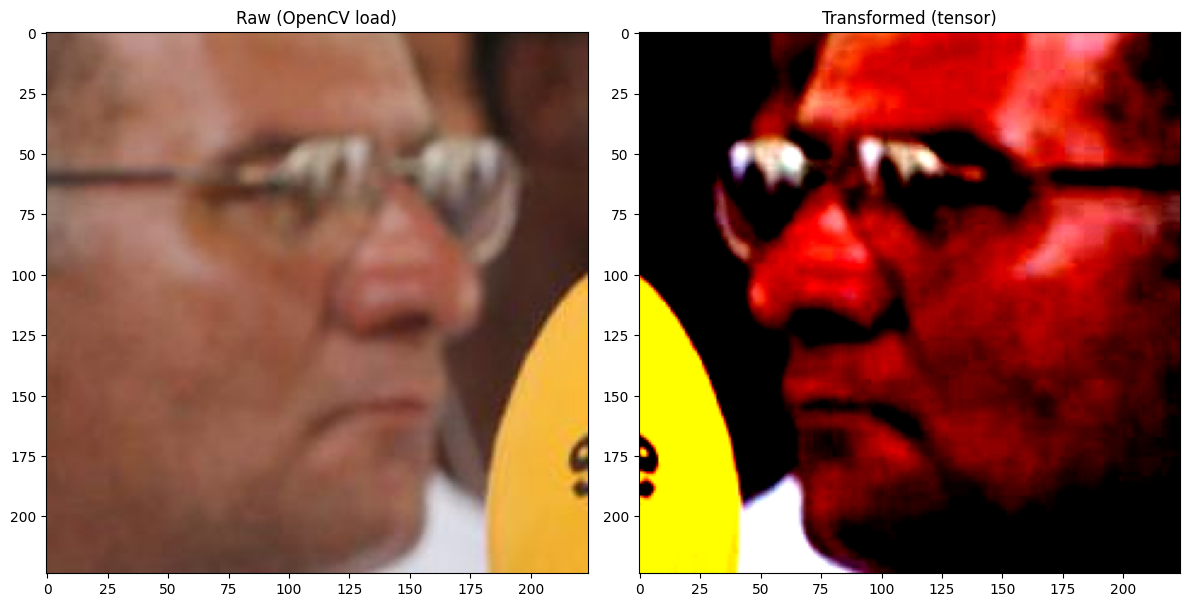

In [ ]:
import os
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

BATCH_SIZE=256

# Args:
#     batch: A list of dicts from FairFaceDataset.__getitem__
#             Each item: {"img_t": tensor, "y": dict, "meta": dict}
# Returns:
#     imgs: Tensor (B, 3, 224, 224) -> For GPU
#     targets: Dict of Tensors -> For GPU
#     metas: List of dicts -> Remains on CPU
def fairface_training_collate(batch):
    # 1. Collate Images: Stack list of (3, 224, 224) into (B, 3, 224, 224)
    imgs = torch.stack([item["img_t"] for item in batch])

    # 2. Collate Targets (y): Group each attribute into its own tensor
    targets = {
        "age": torch.stack([item["y"]["age"] for item in batch]),
        "gender": torch.stack([item["y"]["gender"] for item in batch]),
        "race": torch.stack([item["y"]["race"] for item in batch]),
    }

    # 3. Collate Metadata: Keep as a simple list (no stacking/tensor conversion)
    # This prevents default_collate from trying to process strings as tensors
    metas = [item["meta"] for item in batch]

    return imgs, targets, metas


# Define common arguments to keep code DRY (Don't Repeat Yourself)
common_params = {
    "batch_size": BATCH_SIZE,
    "num_workers": min(8, os.cpu_count() or 4),  # try 8; tune for your machine
    "pin_memory": True,
    "persistent_workers": True,
    "prefetch_factor": 4,
    "collate_fn": fairface_training_collate,
}

train_loader = DataLoader(train_ds, shuffle=True, **common_params)
valid_loader = DataLoader(val_ds, shuffle=False, **common_params)
test_loader  = DataLoader(test_ds,  shuffle=False, **common_params)

# smoke test (loads an actual image)
# batch = next(iter(train_loader))
imgs, targets, m = next(iter(train_loader))

print(m)

x = imgs        # Tensor [B, C, H, W]
y = targets     # dict of tensors
meta = m[0]      # dict (strings collated as list)

print("x:", x.shape, x.dtype)
print("y:", {k: v for k, v in y.items()})
print("example file:", meta["file"])
print("example path:", meta["path"])
print("mode:", meta["mode"])

# pick first sample in the batch
img_path = meta["path"]

# --- raw (as loaded) ---
raw_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
assert raw_bgr is not None, f"Could not read: {img_path}"
raw_rgb = cv2.cvtColor(raw_bgr, cv2.COLOR_BGR2RGB)

# --- transformed (what model sees) ---
img_t = x[0]  # [C,H,W], float32
tfm_rgb = img_t.permute(1, 2, 0).clamp(0, 1).cpu().numpy()  # HWC, [0,1]

# --- side-by-side ---
plt.figure(figsize=(12, 7))

plt.subplot(1, 2, 1)
plt.imshow(raw_rgb)
# plt.axis("off")
plt.title("Raw (OpenCV load)")

plt.subplot(1, 2, 2)
plt.imshow(tfm_rgb)
# plt.axis("off")
plt.title("Transformed (tensor)")

plt.tight_layout()
plt.show()


### 2.2.2.1 Backbone interface (input -> embedding)

In [9]:
from torchvision import models
from torchinfo import summary

model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

summary = summary(model, input_size=(1, 3, 256, 512), # (B, C, H, W)
        col_names=("input_size", "output_size", "num_params"),
        depth=4)

print(summary)
print(model)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ResNet                                   [1, 3, 256, 512]          [1, 1000]                 --
├─Conv2d: 1-1                            [1, 3, 256, 512]          [1, 64, 128, 256]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 128, 256]         [1, 64, 128, 256]         128
├─ReLU: 1-3                              [1, 64, 128, 256]         [1, 64, 128, 256]         --
├─MaxPool2d: 1-4                         [1, 64, 128, 256]         [1, 64, 64, 128]          --
├─Sequential: 1-5                        [1, 64, 64, 128]          [1, 64, 64, 128]          --
│    └─BasicBlock: 2-1                   [1, 64, 64, 128]          [1, 64, 64, 128]          --
│    │    └─Conv2d: 3-1                  [1, 64, 64, 128]          [1, 64, 64, 128]          36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 64, 128]          [1, 64, 64, 128]          128
│    │    └─ReLU: 3-3     

In [10]:
class ResNetBackbone34(nn.Module):
    """
    ResNet-34 backbone as a pure feature extractor.

    Input : (B, 3, 224, 224)
    Output: (B, 512)
    """
    def __init__(self, pretrained: bool = True):
        super().__init__()

        weights = models.ResNet34_Weights.DEFAULT if pretrained else None
        self.model = models.resnet34(weights=weights)

        # Remove classifier
        self.out_dim_final = self.model.fc.in_features  # 512
        self.model.fc = nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)  # already (B, 512)

class FairFaceMultiTaskModel(nn.Module):
    """
    ResNet-34 backbone + 3 classification heads (age / gender / race).
    Uses final pooled embedding (B, 512) for all heads.
    """
    def __init__(
        self,
        *,
        num_age_classes: int = 9,
        num_gender_classes: int = 2,
        num_race_classes: int = 7,
        pretrained: bool = True,
        freeze_backbone: bool = False,
        dropout_p: float = 0.2,
    ):
        super().__init__()

        self.backbone = ResNetBackbone34(pretrained=pretrained)

        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

        out_final = self.backbone.out_dim_final  # 512

        # Optional shared projection ("intermediate") like your style
        self.shared = nn.Sequential(
            nn.Linear(out_final, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_p),
        )

        # Heads output logits (no activation)
        self.age_head = nn.Linear(512, num_age_classes)
        self.gender_head = nn.Linear(512, num_gender_classes)
        self.race_head = nn.Linear(512, num_race_classes)

    def forward(self, x: torch.Tensor):
        f_final = self.backbone(x)  # f_final: (B, 512)

        z = self.shared(f_final)

        out = {
            "age": self.age_head(z),
            "gender": self.gender_head(z),
            "race": self.race_head(z),
        }

        return out  # logits dict

In [11]:
def sanity_test_fairface_model(model: nn.Module, *, batch_size: int = 1, h: int = 224, w: int = 224, device=torch.device("cpu")) -> None:
    model = model.to(device).train()

    # 1) Forward shape check
    x = torch.randn(batch_size, 3, h, w, dtype=torch.float32, device=device)
    out = model(x)

    assert isinstance(out, dict), f"Expected dict output, got {type(out)}"
    assert "age" in out and "gender" in out and "race" in out, f"Missing keys: {out.keys()}"

    age_logits = out["age"]
    gender_logits = out["gender"]
    race_logits = out["race"]

    print("age logits   :", tuple(age_logits.shape), age_logits.dtype)
    print("gender logits:", tuple(gender_logits.shape), gender_logits.dtype)
    print("race logits  :", tuple(race_logits.shape), race_logits.dtype)

    # infer class counts from head modules (gold-standard, avoids hardcoding)
    num_age = model.age_head.out_features
    num_gender = model.gender_head.out_features
    num_race = model.race_head.out_features

    assert age_logits.shape == (batch_size, num_age)
    assert gender_logits.shape == (batch_size, num_gender)
    assert race_logits.shape == (batch_size, num_race)

    # 2) Backward / gradient flow check (uses fake labels)
    y_age = torch.randint(0, num_age, (batch_size,), device=device, dtype=torch.long)
    y_gender = torch.randint(0, num_gender, (batch_size,), device=device, dtype=torch.long)
    y_race = torch.randint(0, num_race, (batch_size,), device=device, dtype=torch.long)

    ce = nn.CrossEntropyLoss()
    loss = ce(age_logits, y_age) + ce(gender_logits, y_gender) + ce(race_logits, y_race)

    model.zero_grad(set_to_none=True)
    loss.backward()

    # confirm backbone gets gradients (at least one param)
    got_grad = False
    for p in model.backbone.parameters():
        if p.requires_grad and p.grad is not None:
            got_grad = True
            break

    print("loss:", float(loss.detach().cpu()))
    print("backbone received gradients:", got_grad)

    assert got_grad, "Backbone did not receive gradients (check detach / freezing)."

    print("Sanity test passed.")


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FairFaceMultiTaskModel(pretrained=True, freeze_backbone=False)
sanity_test_fairface_model(model, device=device)

age logits   : (1, 9) torch.float32
gender logits: (1, 2) torch.float32
race logits  : (1, 7) torch.float32
loss: 4.663665294647217
backbone received gradients: True
Sanity test passed.
